# PCA: Principal Component Analysis

PCA learns an orthogonal, linear transformation of the data that projects an input $x$ to a representation $z$, as shown in the figure below. PCA, therefore, is a __dimensionality reduction method__ that preserves as much of the information in the data as possible. [1] 

From information theory, learning that an unlikely event has occured is __more informative__ than learning that a likely event has occured. [1] Again, from information theory, a more disorderly distribution contains more information than an orderly (and in effect, predictive) distribution. IN OTHER WORDS, dimensions with the __largest variance values__, contain the most amount of information. 

Now the question is, can we discard dimensions/information that have small variance? And the answer is yes. In fact, this is the motivation behind PCA. Using vector factorization, we can decompose data and pick few _factors_ with the highest variances. The reduced data can be computed as weighted sums of those _top few vectors_ (aka eigenvectors with the largest eigenvalues). 
<img src="https://intoli.com/blog/pca-and-svd/img/basic-pca.png" alt="Drawing" style="height: 350px;"/>
Image taken from https://intoli.com/blog/pca-and-svd/

In this notebook: 
1. We will apply PCA in some images of CIFAR dataset. Particularly, we will show that we can represent 3072 pixels with just 144 values
2. We will show high-level implementation of PCA using:
    * Singular Value Decomposition, and
    * Eigendecomposition
    
References:
1. [Deep Learning Book by Ian Goodfellow](https://www.deeplearningbook.org/contents/ml.html)
2. [CS231n - Data Preprocessing](http://cs231n.github.io/neural-networks-2/)
3. [Amoeba the prophet of PCA](https://stats.stackexchange.com/questions/314046/why-does-andrew-ng-prefer-to-use-svd-and-not-eig-of-covariance-matrix-to-do-pca) 

In [1]:
import numpy as np
import cifar10
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load dataset
train_x, _ = cifar10.load_dataset()

# We'll only experiment with 20 images
data = train_x[:20]
print(data.shape) # [num_samples, num_channels, heigh, width]

(20, 3, 32, 32)


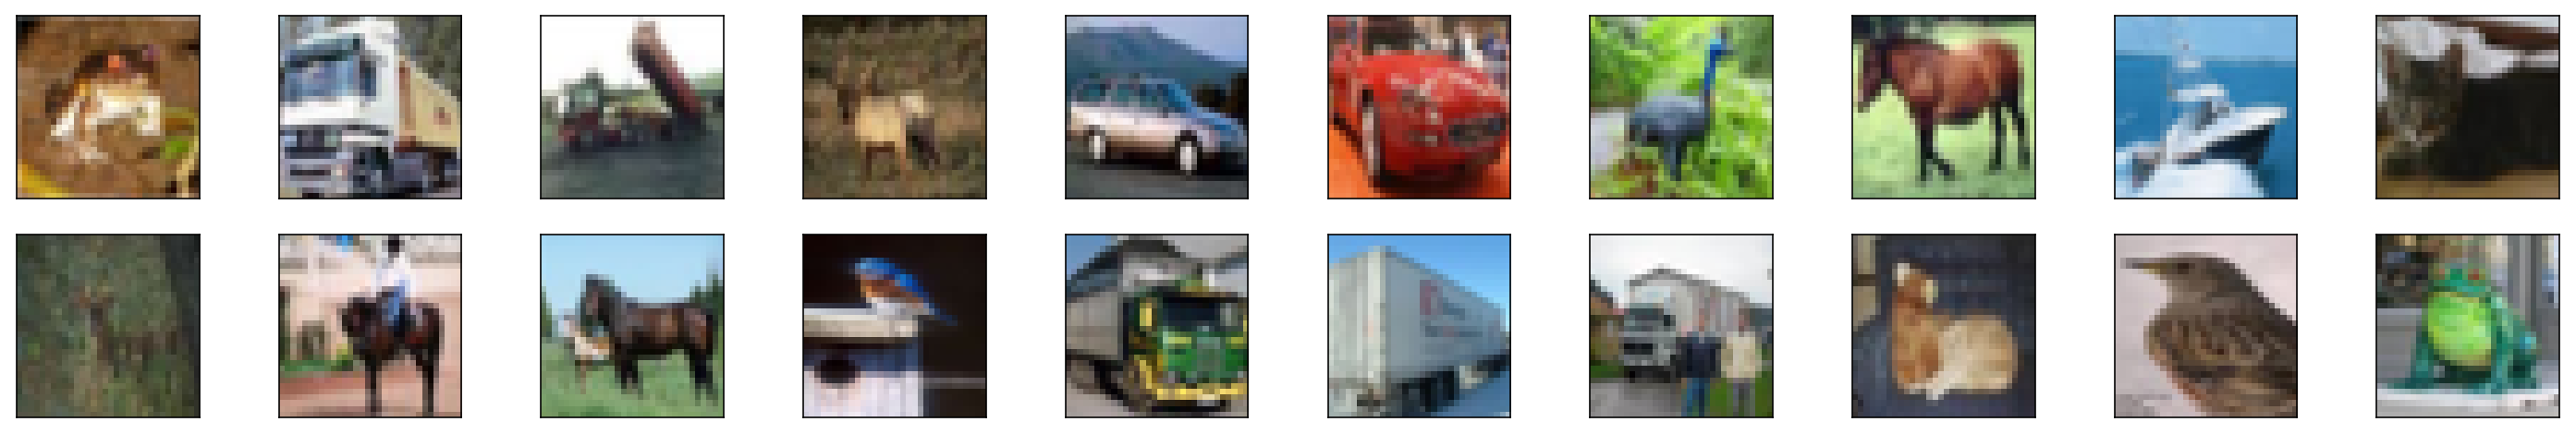

In [3]:
# Visualize some samples of the dataset
def visualize(images):
    fig = plt.figure(figsize=(25, 4))
    for index in np.arange(20):
        ax = fig.add_subplot(2, 20/2, index+1, xticks=[], yticks=[])
        ax.imshow(images[index].clip(0,1))
            
visualize(data.transpose(0,2,3,1)) # matplotlib assumes images of shape [height, width, num_channels]

# PCA Algorithm using SVD

PCA can be divided into 2 phases, (A) Compression, and (B) Recovery

### Compression

1. Zero center the data. This can be done by __subtracting mean of data__.
2. Perform __Singular Value Decomposition on Covariance Matrix__

    * __S__ - contains the square root of the eigenvalues of the covariance matrix and is sorted in descending order, meaning, the largest eigenvalue is the leftmost element. You can think of eigenvalues as representing the variances, therefore it is helpful to sort out eigenvectors according to their corresponding eigenvalues.
    * __U__ - contains the eigenvector of the covariance matrix. This is sorted parallely as S, that is, the eigenvectors correspond to the values in S
    * __V__ - you don't need this. NO, but seriously, if __U__ is the eigenvectors of (A.T * A), then __V__ is the eigenvectors of (A * A.T). In this case, since covariance matrix (A) is a square matrix, __V__ therefore is just the transpose of __U__.
    
    TL;DR: We only need __U__ because __U__ are the _decomposed factors_ used in projecting our data with reduced representation. 
    
3. Project original data in _top few_ eigenvectors.

You can now save the compressed representation of the data. You can also perform analysis on this reduced and cheaper version of your dataset. 

### Recovery

4. Multiply the transpose of _top few_ eigenvectors, to recover the data from the compressed/reduced/projected representation

5. Add mean of the original data to the recovered data.

In [4]:
def PCA(data, num_dim):
    # Reshape the data into flattened vectors [num_samples, -1]
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1)

    # Get the mean and zero center the data
    mean = np.mean(data, axis=0) # per pixel mean
    data = data - mean

    # Get the covariance matrix
    cov = np.dot(data.T, data)
    
    # Perform factor Decomposition, using SVD
    U, S, V = np.linalg.svd(cov)
    
    # Project the data using fewer eigenvectors - [Compressed Representation] 
    data_compressed = np.dot(data, U[:, :num_dim])
    
    # Recover data from the compressed representation
    data_recovered = np.dot(data_compressed, U[:, :num_dim].transpose())
    
    # Add mean
    data_recovered += mean
    
    return data_recovered, U

new_data_svd, U = PCA(data, 144)


(20, 3072)


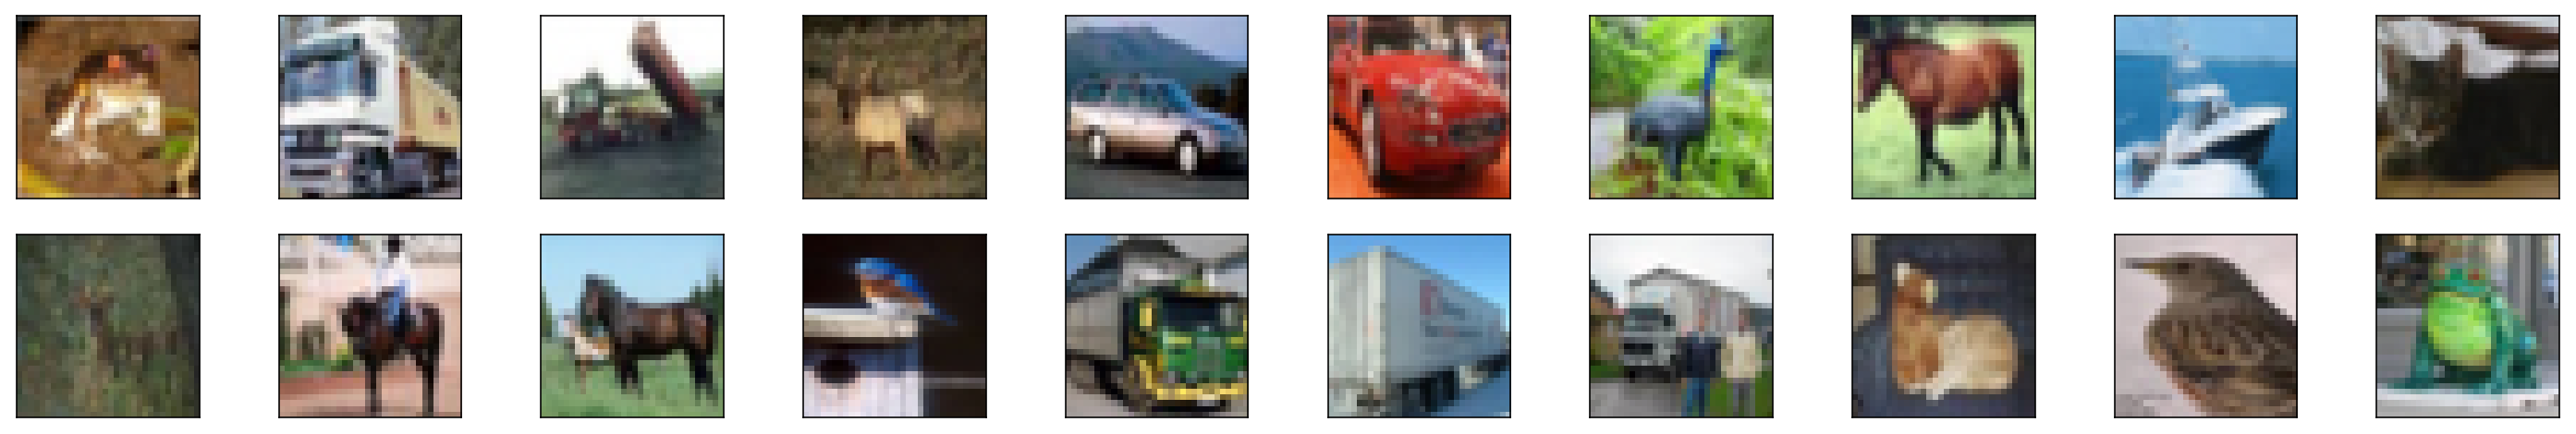

In [5]:
print(new_data_svd.shape)
visualize(new_data_svd.reshape(-1,3,32,32).transpose(0,2,3,1))

# Faster PCA Algorithm using Eigendecomposition

Apparently, faster PCA calculation can be realized by using some tricks in Numpy.

1. Instead of manually calculating the covariance, use np.conv()
2. Instead of using SVD, using eigendecomposition. 

Eigendecomposition is just a special case of SVD, that is, eigendecomposition only works for square matrices. In our case, since we are passing covariance matrix, which in fact is a square matrix, to SVD, we can therefore use __np.linalg.eigh()__ to do decomposition. __np.linalg.eigh()__ is at least __3 times faster__ than np.linalg.svd() in small datasets

In [6]:
def PCA_faster(data, num_dim):
    # Reshape the data into flattened vectors [num_samples, -1]
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1)

    # Get the mean and zero center the data
    mean = np.mean(data, axis=0) # per pixel mean
    data = data - mean

    # Get the covariance matrix, Numpy has few tricks in computing covariance
    cov = np.cov(data.T)
    
    # Perform factor Decomposition, using SVD
    S, V = np.linalg.eigh(cov)
    
    # V is originally sorted in ascending eigenvalue, we want the opposite sorting
    V = np.fliplr(V)
    
    # Project the data using fewer eigenvectors - [Compressed Representation] 
    data_projected = np.dot(data, V[:, :num_dim])
    
    # Recover data from the compressed representation
    data_recovered = np.dot(data_projected, V[:, :num_dim].transpose())
    
    # Add mean
    data_recovered += mean
    
    return data_recovered, V
    
new_data_eigh, V = PCA(data, 144)

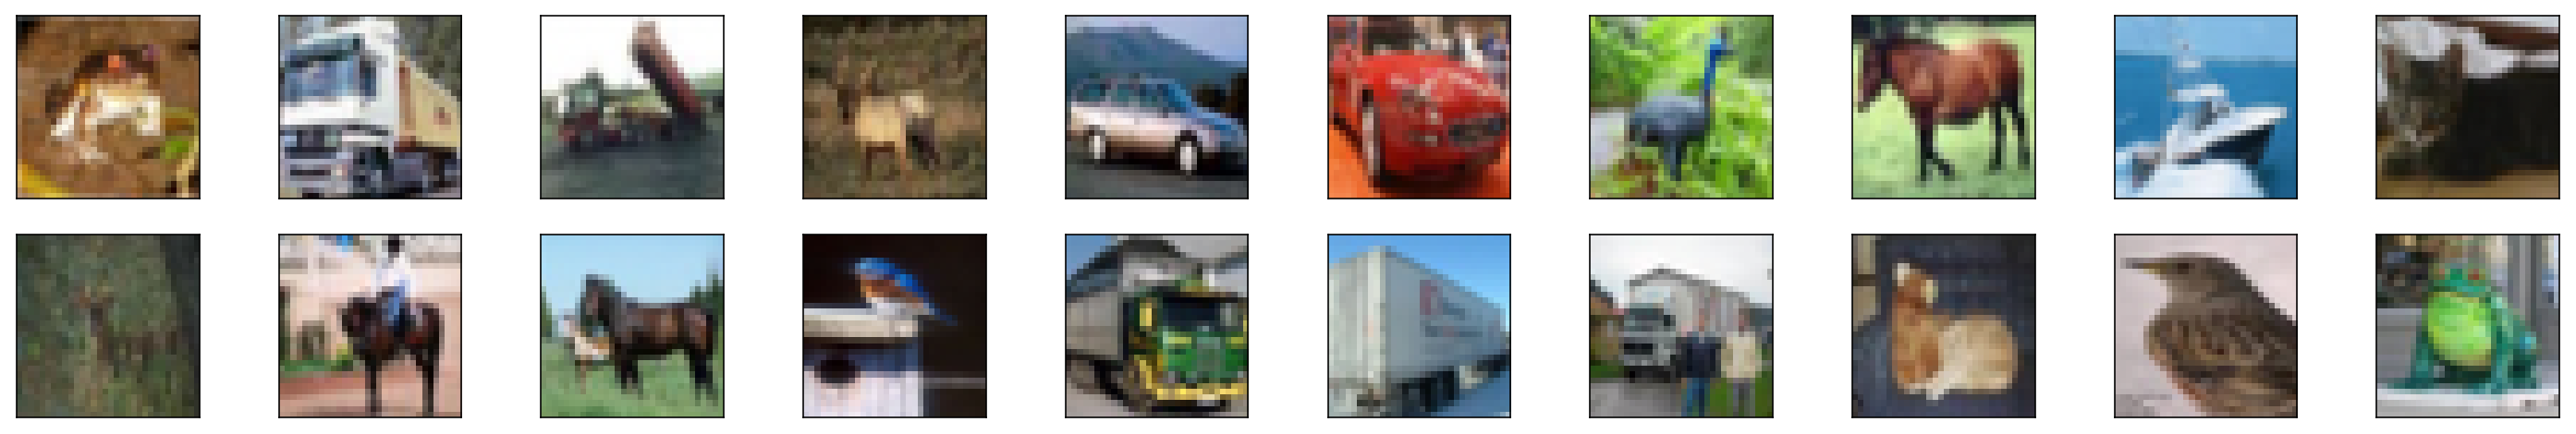

In [7]:
visualize(new_data_eigh.reshape(-1,3,32,32).transpose(0,2,3,1))

# PCA with SVD vs PCA with Eigendecomposition

Let's try applying PCA on whole CIFAR using those 2 implementations.

In [10]:
import time

train_x = train_x.reshape(train_x.shape[0], -1)

start = time.time()
new_cifar_svd, _ = PCA(train_x, 144)
print("PCA with SVD: {} seconds".format(time.time() - start))

start_2 = time.time()
new_cifar_eigh, _ = PCA_faster(train_x, 144)
print("PCA with Eigendecomposition: {} seconds".format(time.time() - start_2))


PCA with SVD: 33.422234773635864 seconds
PCA with Eigendecomposition: 28.98323154449463 seconds


# Conclusion

So that's it. PCA! Did you notice any differences between the three data? 

### To summarize, PCA is just like natural selection minus mutation. PCA prioritizes _valuable members_ and also, discards those who are __WORTHLESS__ and _unpromising_! The overall population therefore is assumed to be represented as sum of those valuable members.